# Model Tuning

Parameter tuning for KNeighbors classifier

# 1)-Importing key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# What's life without style :). So, let's add style to our dataframes
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
# For data processing and maths
import numpy as np
import pandas as pd
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# 2)-Loading data

Source:https://www.kaggle.com/c/titanic

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


"NaN" is not a string, rather it's a special value: numpy.nan

In [6]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [7]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

**checking difference in features**

In [9]:
train.columns.difference(test.columns)

Index(['Survived'], dtype='object')

**Only target variable is difference**

# 3)- Exploring data

### 3.1)-Checking all variables with their data-type

In [10]:
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(train)
table_dtype

,Data Type
PassengerId,int64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Age,float64
Fare,float64
Name,object
Sex,object
Ticket,object


### 3.2)- Checking missing values

In [11]:
def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

In [12]:
missing_values = find_missing_values(train, columns=train.columns)
missing_values

Number of missing or NaN values for each column:


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [13]:
missing_values = find_missing_values(test, columns=test.columns)
missing_values

Number of missing or NaN values for each column:


{'PassengerId': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 86,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 1,
 'Cabin': 327,
 'Embarked': 0}

**Treating missing values**

remove ‘Cabin’, ‘Name’ and ‘Ticket’ columns as they require some processing to extract useful features

In [14]:
train.pop('Cabin')
train.pop('Name')
train.pop('Ticket')
train.shape

(891, 9)

In [15]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')

**Fill the missing age values by the mean value**

In [16]:
train['Age'] = train['Age'].fillna(train['Age'].mean())

**Fill the missing ‘Embarked’ values by the most frequent value**

In [17]:
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

**‘Pclass’ is a categorical feature so we convert its values to strings**

In [18]:
train['Pclass'] = train['Pclass'].apply(str)

### 3.3)-Dealing with categorical variables

one hot encoding of categorical features

In [19]:
# Getting Dummies from all other categorical vars
for col in train.dtypes[train.dtypes == 'object'].index:
    for_dummy = train.pop(col)
    train = pd.concat([train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [20]:
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


# 4)- Model

In [21]:
#pop() is an inbuilt function in Python that removes and returns last value from the list or the given index value
labels = train.pop('Survived')

In [22]:
labels[:5]

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### 4a)-train-test split

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.25)

### 4b) fit the model

In [24]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [25]:
y_pred = model.predict(x_test)

### 4c)-Evaluation

We will AUC (Area Under Curve) as the evaluation metric. Our target value is binary so it’s a binary classification problem. AUC is a good way for evaluation for this type of problems

In [26]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5848648648648649

# 5)- Model Tuning

### 5.1)-n_neighbors
n_neighbors represents the number of neighbors to use for kneighbors queries

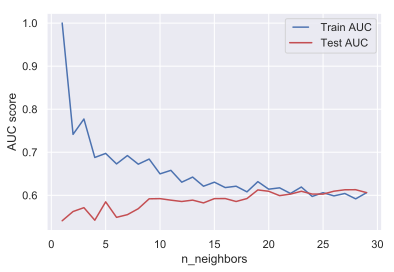

In [27]:
neighbors = list(range(1,30))
train_results = []
test_results = []
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(neighbors, train_results, 'b', label="Train AUC")
line2, = plt.plot(neighbors, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.show()

Using n_neighbors=1 means each sample is using itself as reference, that’s an overfitting case. For our data, increasing the number of neighbors improves the test scores

### 5.2)-p in L_p distance
This is the power parameter for the Minkowski metric. When p=1, this is equivalent to using manhattan_distance(l1), and euliddean_distance(l2) for p=2. For arbitrary p, minkowski distance (l_p) is used

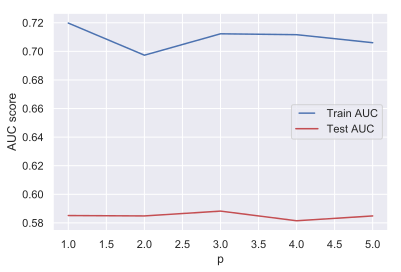

In [28]:
distances = [1, 2, 3, 4, 5]
train_results = []
test_results = []
for p in distances:
    model = KNeighborsClassifier(p=p)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(distances, train_results, 'b', label="Train AUC")
line2, = plt.plot(distances, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('p')
plt.show()

In most cases, the choice is always between l1 and l2 but it’s interesting to see the results of higher minkowski distances. For our data, using l1 seems to be better than l2 and other l_p distances